### References

- https://adversarial-ml-tutorial.org/adversarial_examples/
- https://arxiv.org/pdf/1905.02175.pdf

In [1]:
import tensorflow as tf
from tensorflow import keras as K
import tensorflow_datasets as tfds

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE


tensorflow version 2.7.0
keras version 2.7.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Dec  6 17:56:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def build_cnn_model(n_layers, n_filters, kernel_size=3, n_classes=10, model_name='basic_cnn'):
    """Builds basic CNN model for adversarial training; will need to be refactored
    non-using default train setup"""
    input_layer = tf.keras.layers.Input(shape=(28,28,1))
    
    # Add basic convolutional_layer
    hidden = tf.keras.layers.Conv2D(n_filters, kernel_size=3, strides=2, activation = 'relu')(input_layer)
    # Add single dense, non-linear layer
    hidden = tf.keras.layers.Flatten()(hidden)
    hidden = tf.keras.layers.Dense(16, activation = 'relu')(hidden)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(hidden) # softmax since multiclass class. problem
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [5]:
def normalize(img, label):
    return img / 255, label

def make_tf_data(raw_ds):
    ds = raw_ds.map(normalize)
    return ds

In [6]:
train_ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True, batch_size=32)
test_ds = tfds.load('mnist', split='test', shuffle_files=True, as_supervised=True, batch_size=32)

train_ds = make_tf_data(train_ds)
test_ds = make_tf_data(test_ds)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Train Standard Classifier

In [16]:
def standard_training(model, train_ds, test_ds, attack=None, epochs=5, verbose=True, **kwargs):
    """Runs the "standard" training loop described in Ilyas et al. (2019)
    
    Standard training includes non-adversarial training during each training step. Includes
    optional adversarial attacks at test time described by the `attack` argument
    
    Args:
        - model (TFModel): A compiled TF / Keras model
        - train_ds (TFData): a tensorflow data object for the training data
        - test_ds (TFData): a tensorflow data object for the test data 
        - attack (function): an attack function (i.e. PGD L2) to perturb
                test data if evaluating adversarial performance. Default : None
        - epochs (int): number of epochs to run training. Default: 5.
        - verbose (bool): Report results after each epoch. Otherwise
                will return the train / test accuracies at the end of training. 
                Default: True"""

    for n in range(epochs):
    
        t = time.time()
        train_losses = []
        train_accs = []
        for b in train_ds: # we're going to get multiple batches over a single epoch
            X, y = b

            l, acc = model.train_on_batch(X, y) # Does one gradient update on a single batch
            train_losses.append(l)
            train_accs.append(acc)

        test_losses = []
        test_accs = []
        for vb in test_ds:
            Xtest, ytest = vb
            
            # When attack is specified (ie not None), apply
            # attack at test time; do not apply in training due to
            # 'standard_training' definition
            if attack is not None:
                # delta = pgd_l2_adv(C_model, X, t, epsilon=0.5, alpha=0.1, num_iter=50)
                delta = attack(model, Xtest, ytest, epsilon=0.5, alpha=0.1, num_iter=50)
                Xdtest = Xtest + delta
            else:
                Xdtest = Xtest
            
            l, acc = model.test_on_batch(Xdtest, ytest)
            test_losses.append(l)
            test_accs.append(acc)
        
        train_loss = sum(train_losses) / len(train_losses) # Across entire epoch, scalar
        train_acc = sum(train_accs) / len(train_accs)
        
        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)
        
        if verbose:
            print(f"Epoch {n+1}/{epochs}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
                Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")
    
    # Return the model
    return model

    # # Return final train and test losses
    # if verbose == False:
    #     return {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}

In [8]:
# C_model is a standard model trained on the original dataset
C_model = build_cnn_model(1, 32) # 1st arg is number of layers, 2nd arg is number of filters in Conv2 layer
C_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

C_model = standard_training(C_model, train_ds, test_ds, attack=None, epochs=5, verbose=True)

Epoch 1/5, Time: 31.65 -- Train Loss: 0.28,                 Train Acc: 0.92, Test Loss: 0.12, Test Acc: 0.96
Epoch 2/5, Time: 15.51 -- Train Loss: 0.11,                 Train Acc: 0.97, Test Loss: 0.09, Test Acc: 0.97
Epoch 3/5, Time: 15.50 -- Train Loss: 0.08,                 Train Acc: 0.98, Test Loss: 0.08, Test Acc: 0.97
Epoch 4/5, Time: 15.60 -- Train Loss: 0.06,                 Train Acc: 0.98, Test Loss: 0.08, Test Acc: 0.98
Epoch 5/5, Time: 15.49 -- Train Loss: 0.05,                 Train Acc: 0.98, Test Loss: 0.08, Test Acc: 0.98


# Generate Non-Robust Dataset

In [9]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(Z[0,:,:,:]) # This is L2 norm by default
    # tf.norm(Z[0,:,:,:], ord=np.inf) # This is for L-inf ball

# PGD L2 for Adversarial Examples #
def single_pgd_step_adv(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta)) # comparing to label for original data point

    grad = tape.gradient(loss, delta)
    delta += alpha*grad / norm(grad) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    # Note: ^ What does min and max do? It seems to make sure that when we add delta to X later, X is in [0,1]
    # Distinguishes _adv from _robust – bounds the change to the image
    delta *= epsilon / tf.clip_by_value(norm(delta), epsilon, np.inf)
    # Note: Ask Mark and Kevin
    
    return delta, loss
    
@tf.function
def pgd_l2_adv(model, X, y, alpha, num_iter, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = single_pgd_step_adv(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

In [10]:
%%time

original_train = []
non_robust_train = []
t_train = [] 
y_train = []


start_time = time.time()
# Loops through entire train dataset image-by-image
for i, b in enumerate(train_ds.unbatch()): # Unbatch splits batches into individual images
    i+=1
    X, y = b
    X = tf.expand_dims(X, 0) # 1st dimension is batch size
    X_t = X

    # Generate a random label, get the delta and add in the perturbation
    t = np.random.randint(0, 10)
    delta = pgd_l2_adv(C_model, X, t, epsilon=0.5, alpha=0.1, num_iter=50)
    X_t += delta
    X_t = X_t[0,:,:,:]
    X = X[0,:,:,:]

    # Append this image and label to the list
    original_train.append(X)
    y_train.append(y)
    non_robust_train.append(X_t)
    t_train.append(t)

    if i%1000 == 0:
        elapsed = time.time() - start_time
        print(f'Unrobustified {i} images in {elapsed:0.3f} seconds')
        start_time = time.time()

original_ds   = tf.data.Dataset.from_tensor_slices((original_train, y_train)).batch(32)
non_robust_ds = tf.data.Dataset.from_tensor_slices((non_robust_train, t_train)).batch(32)

Unrobustified 1000 images in 92.813 seconds
Unrobustified 2000 images in 30.600 seconds
Unrobustified 3000 images in 30.566 seconds
Unrobustified 4000 images in 30.479 seconds
Unrobustified 5000 images in 30.382 seconds
Unrobustified 6000 images in 30.414 seconds
Unrobustified 7000 images in 30.390 seconds
Unrobustified 8000 images in 30.435 seconds
Unrobustified 9000 images in 30.209 seconds
Unrobustified 10000 images in 30.412 seconds
Unrobustified 11000 images in 30.536 seconds
Unrobustified 12000 images in 30.499 seconds
Unrobustified 13000 images in 30.333 seconds
Unrobustified 14000 images in 30.308 seconds
Unrobustified 15000 images in 30.368 seconds
Unrobustified 16000 images in 30.237 seconds
Unrobustified 17000 images in 30.384 seconds
Unrobustified 18000 images in 30.394 seconds
Unrobustified 19000 images in 30.316 seconds
Unrobustified 20000 images in 30.266 seconds
Unrobustified 21000 images in 30.135 seconds
Unrobustified 22000 images in 30.307 seconds
Unrobustified 23000

In [11]:
print(type(original_ds))
print(type(non_robust_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


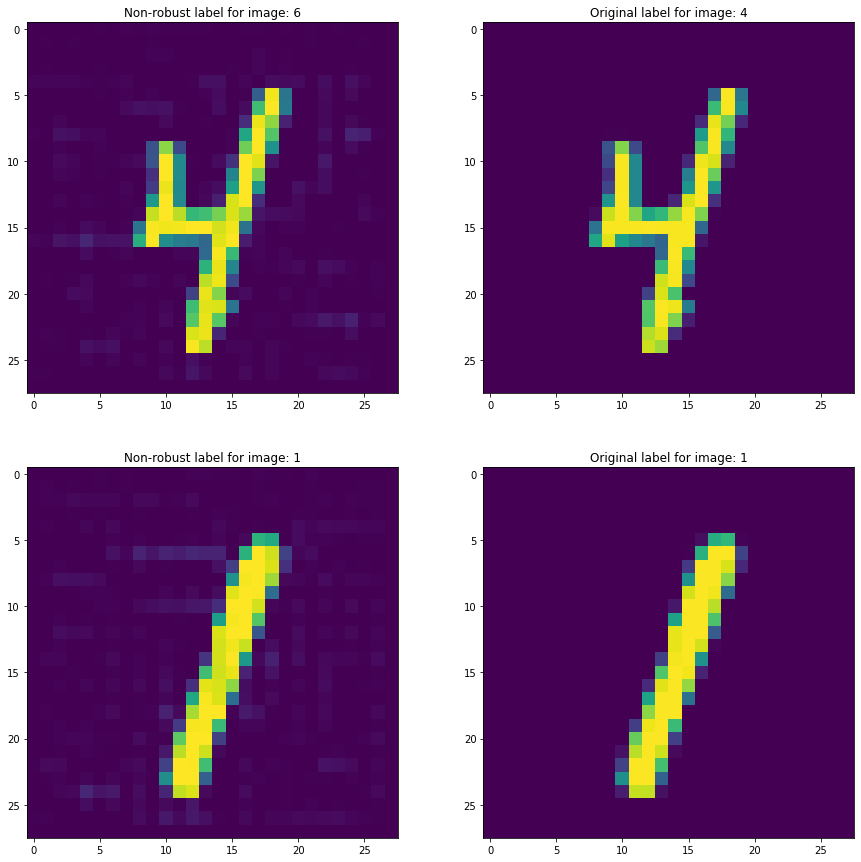

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

for i, b in enumerate(non_robust_ds.unbatch()):
    X, t = b
    ax[i,0].imshow(X.numpy().squeeze())
    ax[i,0].set_title(f'Non-robust label for image: {t}')
    
    if i == 1:
      break

for i, b in enumerate(original_ds.unbatch()):
    X, y = b
    ax[i,1].imshow(X.numpy().squeeze())
    ax[i,1].set_title(f'Original label for image: {y}')

    if i == 1:
      break


In [13]:
tf.data.experimental.save(
    non_robust_ds, 'non_robust_ds')
tf.data.experimental.save(
    original_ds, 'original_ds')

In [18]:
# exporting the tf data from Colab to my drive
from google.colab import drive
drive.mount("/content/gdrive")

!cp -r "/content/nonrobust_train_ds" "/content/gdrive/My Drive/"
!cp -r "/content/original_train_ds" "/content/gdrive/My Drive/"

Mounted at /content/gdrive


# Perform Standard Training on Non-robust dataset

In [14]:
# here we are taking the non robust training dataset, training a standard classifier, and seeing its performance on the unmodified test set

standard_model_non_robust_train = build_cnn_model(1, 32) # 1st arg is number of layers, 2nd arg is number of filters in Conv2 layer
standard_model_non_robust_train.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

standard_model_non_robust_train = standard_training(standard_model_non_robust_train, non_robust_ds, test_ds, attack=None, epochs=5, verbose=True)

Epoch 1/5, Time: 16.45 -- Train Loss: 0.78,                 Train Acc: 0.75, Test Loss: 2.70, Test Acc: 0.28
Epoch 2/5, Time: 16.09 -- Train Loss: 0.16,                 Train Acc: 0.95, Test Loss: 3.58, Test Acc: 0.27
Epoch 3/5, Time: 15.79 -- Train Loss: 0.08,                 Train Acc: 0.98, Test Loss: 4.39, Test Acc: 0.25
Epoch 4/5, Time: 15.83 -- Train Loss: 0.05,                 Train Acc: 0.99, Test Loss: 4.71, Test Acc: 0.28
Epoch 5/5, Time: 16.15 -- Train Loss: 0.03,                 Train Acc: 0.99, Test Loss: 5.17, Test Acc: 0.26


In [17]:
# here we are taking the non robust training dataset, training a standard classifier, and seeing its performance on the test set that has a PGD L2 attack

standard_model_non_robust_train = build_cnn_model(1, 32) # 1st arg is number of layers, 2nd arg is number of filters in Conv2 layer
standard_model_non_robust_train.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

standard_model_non_robust_train = standard_training(standard_model_non_robust_train, non_robust_ds, test_ds, attack=pgd_l2_adv, epochs=5, verbose=True)

Epoch 1/5, Time: 37.09 -- Train Loss: 0.78,                 Train Acc: 0.76, Test Loss: 36.56, Test Acc: 0.00
Epoch 2/5, Time: 25.25 -- Train Loss: 0.15,                 Train Acc: 0.96, Test Loss: 49.64, Test Acc: 0.00
Epoch 3/5, Time: 25.23 -- Train Loss: 0.08,                 Train Acc: 0.98, Test Loss: 60.11, Test Acc: 0.00
Epoch 4/5, Time: 25.24 -- Train Loss: 0.05,                 Train Acc: 0.99, Test Loss: 68.28, Test Acc: 0.00
Epoch 5/5, Time: 41.07 -- Train Loss: 0.03,                 Train Acc: 0.99, Test Loss: 76.23, Test Acc: 0.00
